In [1]:
import pandas as pd
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from datetime import timedelta
import requests
from datetime import datetime, timedelta
import pytz

### 1. Collect data for the last 14 years - from 2010 to 2023 in daily granularity.
### 2. Identify top 10 outliers in each year.

In [2]:
def calculate_daily_returns(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['daily_return'] = (df['c'] - df['prev_close']) / df['prev_close']
    df['abs_daily_return'] = df['daily_return'].abs()
    return df

def get_top_outliers(df, n=10):
    return df.nlargest(n, 'abs_daily_return')

# Define the API key and base URL
api_key = 'beBybSi8daPgsTp5yx5cHtHpYcrjp5Jq'

# Define the currency pairs and years
pair = "C:USDCAD"
years = range(2010, 2024)

# Initialize DataFrames
stats_data = pd.DataFrame(columns=['Year', 'Mean', 'Variance', 'Skewness', 'Kurtosis'])
full_data = pd.DataFrame()
outliers_data = pd.DataFrame()

# Loop over each year
for year in years:
	# Format the API endpoint
	start_date = f'{year}-01-01'
	end_date = f'{year}-12-31'
	url = f"https://api.polygon.io/v2/aggs/ticker/{pair}/range/1/day/{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
	
	# Make the API request
	response = requests.get(url)
	data = response.json()
	
	# Check if the request was successful
	if response.status_code == 200 and 'results' in data:
		# Load data into a DataFrame
		df = pd.DataFrame(data['results'])
        # Converting timestamps
		df['date'] = pd.to_datetime(df['t'], unit='ms')
		df.drop(columns=['t'], inplace=True)
        # Calculating returns
		df = calculate_daily_returns(df)
        
		# Calculate basic statistical properties of the daily returns
		returns = df['daily_return'] 
		mean_return = returns.mean()
		variance_return = returns.var()
		skewness_return = skew(returns)
		kurtosis_return = kurtosis(returns)

		# Collect stats data by year
		year_stats = pd.DataFrame([[year, mean_return, variance_return, skewness_return, kurtosis_return]],
									columns=['Year', 'Mean', 'Variance', 'Skewness', 'Kurtosis'])
		stats_data = pd.concat([stats_data, year_stats], ignore_index=True)

		# Append the data to the full_data DataFrame for the current currency pair
		df['year'] = year
		full_data = pd.concat([full_data, df], ignore_index=True)

		# Find the top 10 outliers based on absolute values of the daily return value
		df['abs_daily_return'] = df['c'].abs()
		outliers = df.nlargest(10, 'abs_daily_return')

		# Append outliers to the outliers_data DataFrame for the current currency pair
		outliers['year'] = year
		outliers_data = pd.concat([outliers_data, outliers], ignore_index=True)

# Sort the data by date so that visualization could be done in a better way         
sorted_full_data = full_data.sort_values(by="date")
sorted_outliers_data = outliers_data.sort_values(by="date")

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_55183/1795670200.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats_data = pd.concat([stats_data, year_stats], ignore_index=True)


In [3]:
sorted_full_data

,v,vw,o,c,h,l,n,date,prev_close,daily_return,abs_daily_return,year
0,1253,1.0474,1.05156,1.04694,1.05173,1.04584,1253,2010-01-03,NaN,NaN,NaN,2010
1,59307,1.0404,1.04708,1.04082,1.05153,1.03506,59307,2010-01-04,1.04694,-0.005846,0.005846,2010
2,71833,1.0377,1.04083,1.03937,1.04102,1.03349,71833,2010-01-05,1.04082,-0.001393,0.001393,2010
3,70380,1.0356,1.03938,1.03177,1.04091,1.03108,70380,2010-01-06,1.03937,-0.007312,0.007312,2010
4,77015,1.0333,1.03177,1.03411,1.03719,1.02897,77015,2010-01-07,1.03177,0.002268,0.002268,2010
...,...,...,...,...,...,...,...,...,...,...,...,...
4430,85045,1.3228,1.32516,1.31949,1.32618,1.31795,85045,2023-12-26,1.32517,-0.004286,0.004286,2023
4431,101776,1.3200,1.31965,1.32045,1.32193,1.31750,101776,2023-12-27,1.31949,0.000728,0.000728,2023
4432,116482,1.3208,1.32045,1.32280,1.32390,1.31546,116482,2023-12-28,1.32045,0.001780,0.001780,2023
4433,112236,1.3231,1.32301,1.30958,1.32652,1.30048,112236,2023-12-29,1.32280,-0.009994,0.009994,2023


In [4]:
sorted_outliers_data

,v,vw,o,c,h,l,n,date,prev_close,daily_return,abs_daily_return,year
5,88215,1.0658,1.06598,1.06914,1.06942,1.06217,88215,2010-01-29,1.06588,0.003059,1.06914,2010
8,553,1.0686,1.06969,1.06797,1.07032,1.06793,553,2010-01-31,1.06914,-0.001094,1.06797,2010
1,92911,1.0673,1.06158,1.07191,1.07507,1.05951,92911,2010-02-04,1.06157,0.009740,1.07191,2010
3,119216,1.0717,1.07183,1.06983,1.07797,1.06419,119216,2010-02-05,1.07191,-0.001940,1.06983,2010
2,1188,1.0703,1.06807,1.07118,1.07162,1.06782,1188,2010-02-07,1.06983,0.001262,1.07118,2010
...,...,...,...,...,...,...,...,...,...,...,...,...
132,2453,1.3868,1.38447,1.38634,1.38726,1.38447,2453,2023-10-29,1.38790,-0.001124,1.38634,2023
137,129647,1.3841,1.38633,1.38300,1.38663,1.37573,129647,2023-10-30,1.38634,-0.002409,1.38300,2023
131,142201,1.3853,1.38293,1.38781,1.38920,1.38110,142201,2023-10-31,1.38300,0.003478,1.38781,2023
135,155116,1.3875,1.38770,1.38344,1.38987,1.38321,155116,2023-11-01,1.38781,-0.003149,1.38344,2023


In [5]:
stats_data

,Year,Mean,Variance,Skewness,Kurtosis
0,2010,-0.000146,0.000038,NaN,NaN
1,2011,0.000105,0.000030,NaN,NaN
2,2012,-0.000071,0.000013,NaN,NaN
3,2013,0.000243,0.000011,NaN,NaN
4,2014,0.000288,0.000012,NaN,NaN
5,2015,0.000563,0.000025,NaN,NaN
6,2016,-0.000089,0.000028,NaN,NaN
7,2017,-0.000203,0.000017,NaN,NaN
8,2018,0.000275,0.000015,NaN,NaN
9,2019,-0.000155,0.000009,NaN,NaN


Skewness and Kurtosis (NaN): The NaN values likely indicate that daily returns for many years are very close to zero with little variance, thus not allowing for a meaningful calculation of skewness and kurtosis. This could mean the market is highly stable on a day-to-day basis, with changes being very subtle.

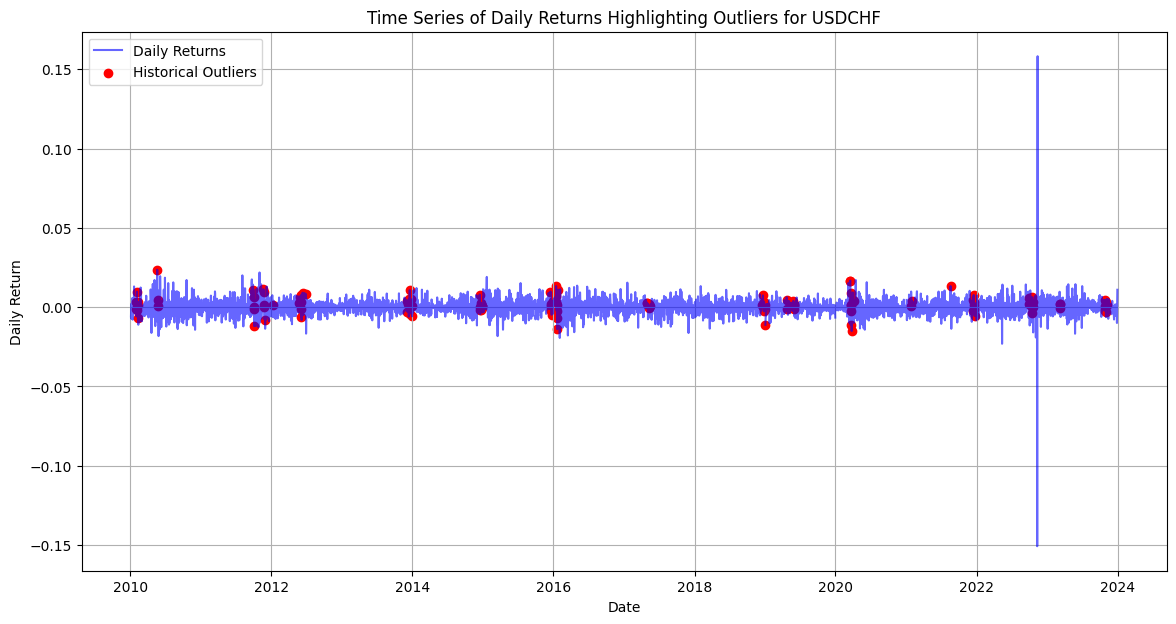

In [6]:
def plot_data_with_outliers(full_data, outliers_data):
    plt.figure(figsize=(14, 7))
    plt.plot(full_data['date'], full_data['daily_return'], label='Daily Returns', color='blue', alpha=0.6)
    plt.scatter(outliers_data['date'], outliers_data['daily_return'], color='red', label='Historical Outliers')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.title('Time Series of Daily Returns Highlighting Outliers for USDCHF')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot data with outliers
plot_data_with_outliers(sorted_full_data, outliers_data)

### 3. Collect data of 3 days prior and post for each of these outliers in hourly granularity.

In [7]:
# Convert dates in dataset to datetime objects
sorted_outliers_data['date'] = pd.to_datetime(sorted_outliers_data['date'])

date_ranges = pd.DataFrame({
    "start_date": sorted_outliers_data['date'] - timedelta(days=3),
    "end_date": sorted_outliers_data['date'] + timedelta(days=3),
    "outlier_date": sorted_outliers_data['date'],
    "year": sorted_outliers_data['year']
})

date_ranges

,start_date,end_date,outlier_date,year
5,2010-01-26,2010-02-01,2010-01-29,2010
8,2010-01-28,2010-02-03,2010-01-31,2010
1,2010-02-01,2010-02-07,2010-02-04,2010
3,2010-02-02,2010-02-08,2010-02-05,2010
2,2010-02-04,2010-02-10,2010-02-07,2010
...,...,...,...,...
132,2023-10-26,2023-11-01,2023-10-29,2023
137,2023-10-27,2023-11-02,2023-10-30,2023
131,2023-10-28,2023-11-03,2023-10-31,2023
135,2023-10-29,2023-11-04,2023-11-01,2023


In [8]:
def calculate_daily_returns(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['returns'] = (df['c'] - df['prev_close']) / df['prev_close']
    return df

def fetch_and_process_hourly_data(symbol, start_date, end_date, api_key):
    # Format the dates as strings for URL
    formatted_start_date = start_date.strftime('%Y-%m-%d')
    formatted_end_date = end_date.strftime('%Y-%m-%d')

    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/hour/{formatted_start_date}/{formatted_end_date}?apiKey={api_key}"
    response = requests.get(url)
    response_data = response.json()

    if response.status_code != 200 or 'results' not in response_data:
        print(f"Failed to fetch data or 'results' not in response: {response.status_code} - {response.text}")
        return None

    df = pd.DataFrame(response_data['results'])
    df['date'] = pd.to_datetime(df['t'], unit='ms')
    df.drop(columns=['t'], inplace=True)

    hourly_data = calculate_daily_returns(df)
    hourly_data.set_index('date', inplace=True)

    # Create full index from start_date to end_date at hourly frequency
    full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')

    # Reindex hourly_data using the full index, filling missing rows with NaN
    hourly_data = hourly_data.reindex(full_index)

    hourly_data.reset_index(inplace=True)
    hourly_data.rename(columns={'index': 'date'}, inplace=True)

    return hourly_data

In [9]:
# Initialize empty DataFrame
all_data = pd.DataFrame()

# Initialize an outlier identifier starting from 1 or any specific number
outlier_id = 1

mst = pytz.timezone('MST7MDT')

# Assuming date_ranges are in a standard format without timezone
for index, row in date_ranges.iterrows():
    # Convert start_date, end_date, and outlier_date to Timestamp for consistent comparison
    # Localize these timestamps to MST
    start_date_ts = mst.localize(pd.Timestamp(row['start_date']))
    end_date_ts = mst.localize(pd.Timestamp(row['end_date']) + pd.Timedelta(days=1))  # Extend the end date by one additional day
    outlier_date_ts = mst.localize(pd.Timestamp(row['outlier_date']))

    # Get hourly data for the range including 3 days before and after the outlier
    hourly_data = fetch_and_process_hourly_data(pair, start_date_ts, end_date_ts, api_key)

    if hourly_data is not None:
        # hourly_data['date'] = hourly_data['date'].dt.tz_localize(mst)  # Common timezone for comparison ease if necessary
        # Assign the current outlier_id to the data
        hourly_data['outlier_id'] = outlier_id

        # Prior data from start_date to outlier_date inclusive
        prior_data = hourly_data[(hourly_data['date'] >= start_date_ts) & (hourly_data['date'] < outlier_date_ts)]
        prior_data["day type"] = "prior day"

        # Outlier data is for the hourly data on the day of the outlier
        outlier_data = hourly_data[hourly_data['date'].dt.date == outlier_date_ts.date()]
        outlier_data["day type"] = "outlier day"

        # Post data from the day after outlier_date to end_date
        post_outlier_ts = outlier_date_ts + pd.Timedelta(days=1)  # Starting the day after the outlier_date
        post_data = hourly_data[(hourly_data['date'] >= post_outlier_ts) & (hourly_data['date'] <= end_date_ts)]
        post_data["day type"] = "post day"

        # Concatenate the data from this iteration to the cumulative DataFrame
        all_data = pd.concat([all_data, prior_data, outlier_data, post_data])

        # Increment the outlier_id for the next iteration
        outlier_id += 1
    else:
        print(f"Data not available for symbol {pair} from {row['start_date'].date()} to {row['end_date'].date()}")

# Optionally, you can reset the index of the final DataFrame if it becomes non-unique after concatenations
all_data.reset_index(drop=True, inplace=True)

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_55183/4033729921.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_55183/2574899778.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_55183/2574899778.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [10]:
all_data

,date,v,vw,o,c,h,l,n,prev_close,returns,outlier_id,day type
0,2010-01-26 00:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,prior day
1,2010-01-26 01:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,prior day
2,2010-01-26 02:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,prior day
3,2010-01-26 03:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,prior day
4,2010-01-26 04:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,prior day
...,...,...,...,...,...,...,...,...,...,...,...,...
23652,2023-11-12 20:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,post day
23653,2023-11-12 21:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,post day
23654,2023-11-12 22:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,post day
23655,2023-11-12 23:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,post day


In [11]:
print(f"Unique DateTime in all_data df: {all_data['outlier_id'].nunique()}")

Unique DateTime in all_data df: 140


In [12]:
# Count the number of rows for each unique outlier_id
outlier_counts = all_data['outlier_id'].value_counts().reset_index()

# Rename the columns for clarity
outlier_counts.columns = ['outlier_id', 'count']

# Print the DataFrame
outlier_counts.head(140)

,outlier_id,count
0,1,169
1,95,169
2,89,169
3,90,169
4,91,169
...,...,...
135,49,169
136,50,169
137,132,168
138,133,168


In [13]:
all_data.head(169)

,date,v,vw,o,c,h,l,n,prev_close,returns,outlier_id,day type
0,2010-01-26 00:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,prior day
1,2010-01-26 01:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,prior day
2,2010-01-26 02:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,prior day
3,2010-01-26 03:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,prior day
4,2010-01-26 04:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,prior day
...,...,...,...,...,...,...,...,...,...,...,...,...
164,2010-02-01 20:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,post day
165,2010-02-01 21:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,post day
166,2010-02-01 22:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,post day
167,2010-02-01 23:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,post day


In [14]:
# Reset the index to have simple numbers and separate "date" and "time" columns
all_data.reset_index(inplace=True)
all_data.rename(columns={'index': 'New'}, inplace=True)

all_data

,New,date,v,vw,o,c,h,l,n,prev_close,returns,outlier_id,day type
0,0,2010-01-26 00:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,prior day
1,1,2010-01-26 01:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,prior day
2,2,2010-01-26 02:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,prior day
3,3,2010-01-26 03:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,prior day
4,4,2010-01-26 04:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,prior day
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23652,23652,2023-11-12 20:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,post day
23653,23653,2023-11-12 21:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,post day
23654,23654,2023-11-12 22:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,post day
23655,23655,2023-11-12 23:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,post day


In [15]:
# Convert date to string format if necessary
all_data['date'] = all_data['date'].astype(str)

# Extract date and time from the date string
all_data['Date'] = all_data['date'].str[:10]
all_data['Time'] = all_data['date'].str[11:19]

# Drop the 'date' column if it's no longer needed
all_data.drop(columns=['date', 'New', 'v'], inplace=True)

In [16]:
all_data

,vw,o,c,h,l,n,prev_close,returns,outlier_id,day type,Date,Time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,prior day,2010-01-26,00:00:00
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,prior day,2010-01-26,01:00:00
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,prior day,2010-01-26,02:00:00
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,prior day,2010-01-26,03:00:00
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,prior day,2010-01-26,04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
23652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,post day,2023-11-12,20:00:00
23653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,post day,2023-11-12,21:00:00
23654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,post day,2023-11-12,22:00:00
23655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,post day,2023-11-12,23:00:00


In [17]:
# Check for duplicate rows
duplicates = all_data[all_data.duplicated()]

# Print the duplicate rows
print("Duplicate rows:")
print(duplicates)

Duplicate rows:
Empty DataFrame
Columns: [vw, o, c, h, l, n, prev_close, returns, outlier_id, day type, Date, Time]
Index: []


In [18]:
# # Convert the 'date' column to datetime
# all_data['date'] = pd.to_datetime(all_data['date'])

# # Set the date column as the index if not already
# all_data.set_index('date', inplace=True)

# # Check for duplicate timestamps
# duplicate_dates = all_data.index.duplicated()

# # Display duplicate timestamps if there are any
# if duplicate_dates.any():
#     print("Duplicate timestamps found:")
#     print(all_data.index[duplicate_dates].unique())
# else:
#     print("No duplicate timestamps found.")

In [26]:
all_data.to_csv("USDCHF_hourly_MST.csv")

In [ ]:
def fetch_and_process_hourly_data(symbol, start_date, end_date, api_key):
    # Format the dates as strings for URL
    formatted_start_date = start_date.strftime('%Y-%m-%d')
    formatted_end_date = end_date.strftime('%Y-%m-%d')

    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/hour/{formatted_start_date}/{formatted_end_date}?apiKey={api_key}"
    response = requests.get(url)
    response_data = response.json()

    if response.status_code != 200 or 'results' not in response_data:
        print(f"Failed to fetch data or 'results' not in response: {response.status_code} - {response.text}")
        return None

    df = pd.DataFrame(response_data['results'])

    print("Data fetched successfully:", df.head())

    # Convert timezone and drop original 't' column
    df['date'] = pd.to_datetime(df['t'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('MST7MDT')
    df.drop(columns=['t'], inplace=True)

    print("After timezone conversion:", df.head())

    hourly_data = calculate_daily_returns(df)
    hourly_data.set_index('date', inplace=True)

    print("After setting index:", hourly_data.head())

    # Full index creation and reindexing
    full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
    full_index = full_index[~((full_index.weekday == 4) & (full_index.hour >= 15) | (full_index.weekday == 6) & (full_index.hour < 15))]

    hourly_data = hourly_data.reindex(full_index)
    print("After reindexing:", hourly_data.head())

    hourly_data.reset_index(inplace=True)
    hourly_data.rename(columns={'index': 'date'}, inplace=True)

    return hourly_data

In [20]:
# # Convert start_date, end_date, and outlier_date to Timestamp for consistent comparison
# start_date_ts = pd.Timestamp("2010-05-22")
# end_date_ts = pd.Timestamp("2010-05-28")
# outlier_date_ts = pd.Timestamp("2010-05-25")

# # Get hourly data for the range including 3 days before and after the outlier
# hourly_data = fetch_and_process_hourly_data(pair, "2010-05-22", "2010-05-28", api_key)

# # Check if hourly_data is not None before processing
# if hourly_data is not None:
# 	# prior_data from start_date to outlier_date inclusive
# 	prior_data = hourly_data[(hourly_data['date'] >= start_date_ts) & (hourly_data['date'] <= outlier_date_ts)]
# 	prior_data["day type"] = "prior day"
	
# 	# post_data from the day after outlier_date to end_date
# 	post_outlier_ts = outlier_date_ts + pd.Timedelta(days=1)  # Starting the day after the outlier_date
# 	post_data = hourly_data[(hourly_data['date'] >= post_outlier_ts) & (hourly_data['date'] <= end_date_ts)]
# 	post_data["day type"] = "post day"

In [21]:
# hourly_data

In [22]:
# prior_data

In [23]:
# post_data

In [24]:
# # Assuming 'hourly_data' is your DataFrame and 'date' is the column with datetime objects
# unique_dates = all_data['date'].dt.date.unique()

# # Printing all unique dates
# print("Unique Dates:")
# for date in unique_dates:
#     print(date)

In [25]:
# # Assuming 'hourly_data' is your DataFrame and 'date' is the column with datetime objects
# unique_dates = date_ranges['outlier_date'].dt.date.unique()

# # Printing all unique dates
# print("Unique Dates:")
# for date in unique_dates:
#     print(date)